In [ ]:
# ✅ 1. 기본 import
import sys
import os
import importlib
import torch
sys.path.append(os.path.join(os.getcwd(), "전처리"))
import merge
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from collections import defaultdict

# ✅ 카톡 파일 지정 (변경 가능)
input_chat_path = "uploads/KakaoTalk_20250511_1625_29_658_유정유정.txt"

c:\Users\yhshi\ToneDetect\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧭 is_mobile = True

📊 [화자별 예측 결과 요약]

🧑 김소연
- informal(친근한 말투): 2800 문장 (35.21%)
- chat_emoticon(이모티콘 자주 쓰는 말투): 4052 문장 (50.96%)
- elder_speech(어르신 말투): 195 문장 (2.45%)
- soft_polite(부드럽고 상냥한 말투): 822 문장 (10.34%)
- formal(격식있는 말투): 83 문장 (1.04%)

🧑 상대
- informal(친근한 말투): 2698 문장 (35.09%)
- soft_polite(부드럽고 상냥한 말투): 901 문장 (11.72%)
- chat_emoticon(이모티콘 자주 쓰는 말투): 3662 문장 (47.63%)
- formal(격식있는 말투): 80 문장 (1.04%)
- elder_speech(어르신 말투): 347 문장 (4.51%)


C:\Users\yhshi\AppData\Local\Temp\ipykernel_30512\575808522.py:82: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\yhshi\ToneDetect\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


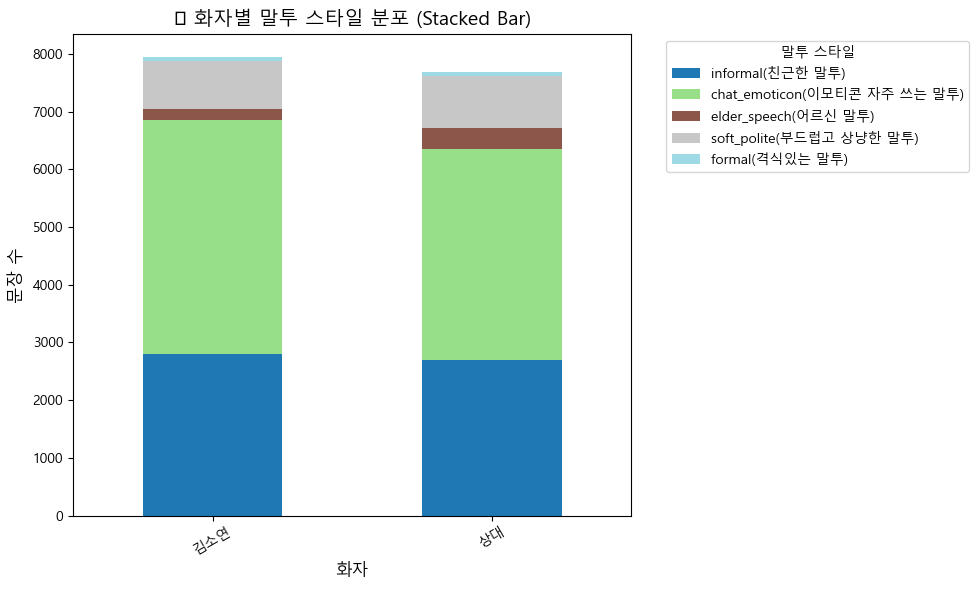

In [3]:
import re

plt.rcParams['font.family'] = 'Malgun Gothic'

# ✅ 3. 모델 로드
ADAPTER_PATH = "Models/ToneDetect_adapter"
BASE_MODEL_NAME = "beomi/kcbert-base"  # 원래 학습할 때 사용한 베이스

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=5)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

# ✅ 4. 예측 함수
def predict_style(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=1).item()
    return pred_class

# ✅ 5. 라벨 정의
label_map = {
    0: "chat_emoticon(이모티콘 자주 쓰는 말투)",
    1: "elder_speech(어르신 말투)",
    2: "formal(격식있는 말투)",
    3: "informal(친근한 말투)",
    4: "soft_polite(부드럽고 상냥한 말투)"
}

# ✅ speaker 별 style_counts 초기화
speaker_style_counts = defaultdict(lambda: defaultdict(int))
clean_sentences = merge.run_merge(input_chat_path, is_mobile=True)

# ✅ 각 문장 예측
for msg in clean_sentences:
    speaker = msg['speaker']
    text = msg['text']

    if (
        not isinstance(speaker, str) or
        speaker.strip() == "" or
        not re.match(r"^[가-힣a-zA-Z0-9]+$", speaker) or
        speaker in ["이모티콘", "사진", "동영상"]
    ):
        speaker = "상대"

    pred = predict_style(text)
    style_name = label_map[pred]
    speaker_style_counts[speaker][style_name] += 1

# ✅ 결과 출력
print("\n📊 [화자별 예측 결과 요약]")
for speaker, style_counts in speaker_style_counts.items():
    print(f"\n🧑 {speaker}")
    total = sum(style_counts.values())
    for style, count in style_counts.items():
        percent = count / total * 100
        print(f"- {style}: {count} 문장 ({percent:.2f}%)")

# ✅ 8. 시각화 (화자별 stacked bar chart 예시)
import pandas as pd

# DataFrame으로 변환
data = []
for speaker, style_counts in speaker_style_counts.items():
    row = {'speaker': speaker}
    row.update(style_counts)
    data.append(row)

df = pd.DataFrame(data).fillna(0)
df.set_index('speaker', inplace=True)

# 시각화
df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("📊 화자별 말투 스타일 분포 (Stacked Bar)", fontsize=14)
plt.xlabel("화자", fontsize=12)
plt.ylabel("문장 수", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title='말투 스타일', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
print(data)

[]


In [92]:
from pprint import pprint

pprint(clean_sentences)

[{'order': 0,
  'speaker': '김소연',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 13, 15, 36)},
 {'order': 1,
  'speaker': '유정유정',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 56)},
 {'order': 2,
  'speaker': '유정유정',
  'text': '6,750원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 57)},
 {'order': 3,
  'speaker': '김소연',
  'text': '5,550원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 14, 52)},
 {'order': 4,
  'speaker': '유정유정',
  'text': '5,550원 받기 완료!',
  'timestamp': datetime.datetime(2023, 10, 14, 15, 35)},
 {'order': 5,
  'speaker': '유정유정',
  'text': '6,750원 자동환불 예정',
  'timestamp': datetime.datetime(2023, 10, 17, 11, 35)},
 {'order': 6,
  'speaker': '김소연',
  'text': '6,750원 받기 완료!',
  'timestamp': datetime.datetime(2023, 10, 17, 11, 36)},
 {'order': 7,
  'speaker': '유정유정',
  'text': '언니! 나 유정인데 혹시 도착해써???',
  'timestamp': datetime.datetime(2025, 3, 18, 8, 27)},
 {'order': 8,
  'speaker': '김소연',
  'text': '아

In [4]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "전처리"))  # chat.py가 전처리 폴더에 있을 때
from chat import full_preprocess

# ✅ clean_sentences는 이미 다음 구조로 존재한다고 가정
# clean_sentences = [{"speaker": ..., "text": ..., "timestamp": ..., "order": ...}, ...]

for item in clean_sentences:
    text = item["text"]
    result = full_preprocess(text)

    item["cleaned"] = result["step3_no_emoticons"]
    item["emotion_chunks"] = result["emotion_chunks"]
    item["extracted_emoticons"] = result["extracted_emoticons"]

print("✅ 전처리 완료: 'cleaned', 'emotion_chunks', 'extracted_emoticons' 필드가 추가됨")

✅ 전처리 완료: 'cleaned', 'emotion_chunks', 'extracted_emoticons' 필드가 추가됨


In [5]:
from pprint import pprint

pprint(clean_sentences)

[{'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 0,
  'speaker': '김소연',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 13, 15, 36)},
 {'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 1,
  'speaker': '유정유정',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 56)},
 {'cleaned': '6,750원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 2,
  'speaker': '유정유정',
  'text': '6,750원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 57)},
 {'cleaned': '5,550원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 3,
  'speaker': '김소연',
  'text': '5,550원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 14, 52)},
 {'cleaned': '5,550원 받기 완료',
  'emotion_chunks': {'[강조]': ['!']},
  'extracted_emoticons': [],
  'order': 4,
  'speaker': '유정유정',
  'text': '5,550원 받기 완료!',
  'timestamp': datetime.datetime(2023, 10

In [7]:
from collections import defaultdict, Counter

# 🔹 화자별 감정 문자열 / 이모티콘 카운터 및 예시 저장
speaker_emotion_counter = defaultdict(Counter)
speaker_emotion_examples = defaultdict(lambda: defaultdict(list))

speaker_emo_counter = defaultdict(Counter)
speaker_emo_examples = defaultdict(lambda: defaultdict(list))

for item in clean_sentences:
    speaker = item["speaker"]
    text = item["text"]

    # ✅ 감정 문자열 처리
    already_added_chunks = set()
    for chunk_list in item.get("emotion_chunks", {}).values():
        for chunk in chunk_list:
            speaker_emotion_counter[speaker][chunk] += 1
            if chunk not in already_added_chunks:
                if len(speaker_emotion_examples[speaker][chunk]) < 3 and text not in speaker_emotion_examples[speaker][chunk]:
                    speaker_emotion_examples[speaker][chunk].append(text)
                already_added_chunks.add(chunk)

    # ✅ 이모티콘 처리
    already_added_emoticons = set()
    for emo in item.get("extracted_emoticons", []):
        speaker_emo_counter[speaker][emo] += 1
        if emo not in already_added_emoticons:
            if len(speaker_emo_examples[speaker][emo]) < 3 and text not in speaker_emo_examples[speaker][emo]:
                speaker_emo_examples[speaker][emo].append(text)
            already_added_emoticons.add(emo)

# 🔹 출력
for speaker in sorted(set(speaker_emotion_counter) | set(speaker_emo_counter)):
    print(f"\n🗣️ 화자: {speaker}")

    # ✅ 감정 문자열: 길이 2 이상만 필터링
    top_chunks = [(chunk, count) for chunk, count in speaker_emotion_counter[speaker].most_common()
                  if len(chunk) >= 2][:3]

    # ✅ 이모티콘: 그대로 사용
    top_emoticons = speaker_emo_counter[speaker].most_common(3)

    # ✅ 감정 문자열 있을 때만 출력
    if top_chunks:
        print("  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):")
        for chunk, count in top_chunks:
            print(f"    - {chunk}: {count}회")
            for example in speaker_emotion_examples[speaker][chunk]:
                print(f"        예시: {example}")

    # ✅ 이모티콘 있을 때만 출력 (길이 제한 없음)
    if top_emoticons:
        print("  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):")
        for emo, count in top_emoticons:
            print(f"    - {emo}: {count}회")
            for example in speaker_emo_examples[speaker][emo]:
                print(f"        예시: {example}")


🗣️ 화자: 김소연
  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):
    - !!: 16회
        예시: 오옹 고생해써!!
        예시: 웅웅 천천히 해!!
        예시: 아구 다행이다ㅠㅠ 미리 알려줄걸 그랬당... 까먹구있었더... 고생했어!!
    - ..: 14회
        예시: 방금 택시탔오 지각이구만..
        예시: 거의 400메간디.. 구글 드라이브로 보내야되나..?
        예시: 구러면 인공지능 활용하는거기도 하고 비슷한 형태끼리 분류되는거징..
    - ??: 8회
        예시: 너는 도착했어??
        예시: 알았또 분석하는거 주석으로 설명 썼어??
        예시: 실행 됐어??
  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):
    - ^^: 1회
        예시: ^!^

🗣️ 화자: 유정유정
  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):
    - !!: 31회
        예시: 나 달구지 타고 가고이써!! 도착해서 자리 잡아둘게 ㅎㅎ
        예시: 헉!!
        예시: 웅!! 조아용~~
    - ??: 26회
        예시: 어모 지금은 어디쯤야??
        예시: 언니 혹시 끝났어??
        예시: 언니 어제 새벽에 과제에 대해서 올라왔더라구 내가 1번은 거의 다 했거덩?? 그래서 정리만 하면 거의 완성인데 2번은 내가 책이 없어서 확인이 어려운데 혹시 시간되면 교재로 해당 페이지 확인해줄 수 있어??
    - ...: 22회
        예시: ㅎㅎ 언니 미안... 또 앞자리얌...
        예시: 저번에 앉았던 그 자리...^^
        예시: 아니 실습도 많다고 했는데 할 수는 있냐구요...
  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):
    - 🥰: 7회
        예시: 일단 페이지 새로 팠어!! 전에 

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ✅ 모델 & 토크나이저 불러오기
MODEL_PATH = "Models/pko-t5-finetuned-chat"  # 너가 학습한 경로
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 정제 함수 정의
def refine_with_model(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # ✅ 수정된 부분

    # model.generate에 no_repeat_ngram_size 파라미터 추가
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,  # 길이 제한 OK
            no_repeat_ngram_size=2,  # 2-gram 이상 반복을 방지
        )
    refined = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return refined.strip()

In [17]:
for item in clean_sentences:
    cleaned_text = item.get("cleaned", "")
    order = item.get("order", "❓")
    if cleaned_text:
        try:
            item["refined"] = refine_with_model(cleaned_text)
            print(f"🔢 order {order}: {item['refined']}")
        except Exception as e:
            print(f"❗ order {order}: '{cleaned_text}' 정제 중 오류 발생:", e)
            item["refined"] = ""  # 실패 시 빈 문자열로 표시

print("✅ 모든 cleaned 문장에 대해 refined 결과 추가 완료")

🔢 order 0: 정산하기를 요청했어요.
🔢 order 1: 정산하기를 요청했어요.
🔢 order 2: 6, 750원을 보냈어요.
🔢 order 3: 5, 550원을 보냈어요.
🔢 order 4: 5, 550원 받기 완료.
🔢 order 5: 6, 750원 자동 환불 예정
🔢 order 6: 6, 750원 받기 완료.
🔢 order 7: 언니, 나 유정인데 혹시 도착했어?
🔢 order 8: 아닝, 나 50분쯤 도착할 것 같아.
🔢 order 9: 너는 도착했어?
🔢 order 10: 나 달구지 타고 가고 있어. 도착해서 자리 잡아줄게.
🔢 order 11: 웅웅, 고마워.
🔢 order 12: 오른쪽에서 세 번째요.
🔢 order 13: 못 찾으면 연락줘.
🔢 order 14: 스타벅스 앞에서 타는 셔틀 40분 꺼를 놓쳐서 50분꺼 기다리고 있었는데 이미 간 거 같아.
🔢 order 15: 택시 타고 올라가야 할 것 같아.
🔢 order 16: 어, 지금은 어디쯤이야?
🔢 order 17: 방금 택시 타고 왔어. 지각이군.
🔢 order 18: 왜?
🔢 order 19: 언니, 혹시 끝나?
🔢 order 20: 아직 수업 중.
🔢 order 21: 헉.
🔢 order 22: 먼저 가고 있을게.
🔢 order 23: 웅웅
🔢 order 24: 오른쪽 앞에서 두 번째 안쪽으로 자리 잡아놨어.
🔢 order 25: 나 방금 끝나서 가는 중.
🔢 order 26: 언니, 미안. 또 앞자리야.
🔢 order 27: 저번에 앉았던 그 자리.
🔢 order 28: https: //github.com/Wegra Lee/deep learning from scratch.
🔢 order 29: gimsoyeon 090.
🔢 order 30: 
🔢 order 31: 졸려. 죽겠다.
🔢 order 32: 나도..
🔢 order 33: 이모티콘 배고팠다.
🔢 order 34: 아니, 오늘 진도 반도 못 나간 것 같은데.
🔢 order 35: 진짜 내 말이.. 이제야 15페이지인 거

In [18]:
from pprint import pprint

pprint(clean_sentences)

[{'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 0,
  'refined': '정산하기를 요청했어요.',
  'speaker': '김소연',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 13, 15, 36)},
 {'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 1,
  'refined': '정산하기를 요청했어요.',
  'speaker': '유정유정',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 56)},
 {'cleaned': '6,750원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 2,
  'refined': '6, 750원을 보냈어요.',
  'speaker': '유정유정',
  'text': '6,750원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 57)},
 {'cleaned': '5,550원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 3,
  'refined': '5, 550원을 보냈어요.',
  'speaker': '김소연',
  'text': '5,550원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 14, 52)},
 {'cleaned': '5,550원 받기 완료',
  'emotion_chunks': {'[강조]': ['!']},
  'extracted

In [43]:
import datetime
from konlpy.tag import Okt
from gensim import corpora
from gensim.models import LdaModel
from collections import defaultdict

# 날짜별로 문장 묶기
grouped_by_date = defaultdict(list)

for item in clean_sentences:
    if 'refined' in item and item['refined'].strip():
        date_key = item['timestamp'].date()  # 날짜만 추출
        grouped_by_date[date_key].append(item['refined'])

# 날짜별로 문장을 하나의 문서로 합치기
documents = [" ".join(sentences) for date, sentences in sorted(grouped_by_date.items())]
date_keys = list(sorted(grouped_by_date.keys()))

print(f"✅ 총 {len(documents)}개 문서 생성됨 (날짜 단위)")

✅ 총 26개 문서 생성됨 (날짜 단위)


In [53]:
# 문서별 원본 단어 수 출력
for idx, doc in enumerate(documents):
    word_count = len(doc.split())
    print(f"📄 문서 {idx + 1}의 단어 수: {word_count}단어")

📄 문서 1의 단어 수: 2단어
📄 문서 2의 단어 수: 12단어
📄 문서 3의 단어 수: 9단어
📄 문서 4의 단어 수: 58단어
📄 문서 5의 단어 수: 23단어
📄 문서 6의 단어 수: 43단어
📄 문서 7의 단어 수: 142단어
📄 문서 8의 단어 수: 45단어
📄 문서 9의 단어 수: 20단어
📄 문서 10의 단어 수: 47단어
📄 문서 11의 단어 수: 2단어
📄 문서 12의 단어 수: 233단어
📄 문서 13의 단어 수: 90단어
📄 문서 14의 단어 수: 40단어
📄 문서 15의 단어 수: 541단어
📄 문서 16의 단어 수: 16단어
📄 문서 17의 단어 수: 23단어
📄 문서 18의 단어 수: 54단어
📄 문서 19의 단어 수: 32단어
📄 문서 20의 단어 수: 64단어
📄 문서 21의 단어 수: 30단어
📄 문서 22의 단어 수: 60단어
📄 문서 23의 단어 수: 185단어
📄 문서 24의 단어 수: 8단어
📄 문서 25의 단어 수: 10단어
📄 문서 26의 단어 수: 83단어


In [58]:
long_docs = [doc for doc in documents if len(doc.split()) >= 50]
print(f"📊 50단어 이상 문서 수: {len(long_docs)} / {len(documents)}")

📊 50단어 이상 문서 수: 10 / 26


In [59]:
pprint(long_docs[0])

('언니, 나 유정인데 혹시 도착했어? 아닝, 나 50분쯤 도착할 것 같아. 너는 도착했어? 나 달구지 타고 가고 있어. 도착해서 자리 '
 '잡아줄게. 웅웅, 고마워. 오른쪽에서 세 번째요. 못 찾으면 연락줘. 스타벅스 앞에서 타는 셔틀 40분 꺼를 놓쳐서 50분꺼 기다리고 '
 '있었는데 이미 간 거 같아. 택시 타고 올라가야 할 것 같아. 어, 지금은 어디쯤이야? 방금 택시 타고 왔어. 지각이군. 왜?')


In [71]:
from konlpy.tag import Komoran
from sklearn.feature_extraction.text import TfidfVectorizer

komoran = Komoran()

# 1. 명사만 추출해서 문서 구성
noun_docs = [" ".join(komoran.nouns(doc)) for doc in long_docs]

# 2. TF-IDF 계산
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(noun_docs)

# 3. 단어 목록 확인
words = vectorizer.get_feature_names_out()

# 문서별로 상위 TF-IDF 단어 추출
top_keywords = []
for row in tfidf_matrix:
    row_array = row.toarray()[0]
    top_indices = row_array.argsort()[::-1][:10]  # 상위 10개
    top_words = [words[i] for i in top_indices if row_array[i] > 0]
    top_keywords.append(top_words)

In [72]:
import numpy as np

# 문서별로 상위 TF-IDF 단어 추출 및 출력
top_keywords = []

for idx, row in enumerate(tfidf_matrix):
    row_array = row.toarray()[0]
    top_indices = row_array.argsort()[::-1][:5]  # 상위 10개
    top_words = [words[i] for i in top_indices if row_array[i] > 0]
    top_keywords.append(top_words)

    print(f"\n📄 문서 {idx + 1}의 주요 단어:")
    for word in top_words:
        print(f" - {word}")


📄 문서 1의 주요 단어:
 - 도착
 - 택시
 - 셔틀
 - 지각
 - 달구지

📄 문서 2의 주요 단어:
 - 과제
 - 주제
 - 페이지
 - 발표
 - 교수

📄 문서 3의 주요 단어:
 - 초대
 - 오키
 - 실행
 - 주피터
 - 드라이브

📄 문서 4의 주요 단어:
 - 버전
 - 폴더
 - 해결
 - 이름
 - 언니

📄 문서 5의 주요 단어:
 - 고생
 - 이모티콘
 - 언니
 - 내용
 - 제출

📄 문서 6의 주요 단어:
 - 미니
 - 선배
 - 프로젝트
 - 의도
 - 자연어

📄 문서 7의 주요 단어:
 - 오늘
 - 과제
 - 시험
 - 교재
 - 아파서

📄 문서 8의 주요 단어:
 - 발표
 - 말씀
 - 안쪽
 - 동영상
 - 최종

📄 문서 9의 주요 단어:
 - 시간
 - 태평역
 - 주말
 - 카페
 - 근처

📄 문서 10의 주요 단어:
 - 버스
 - 건너편
 - 네이버
 - 출발
 - 지도


In [73]:
from gensim import corpora
from gensim.models import LdaModel

# Dictionary, Corpus 생성
dictionary = corpora.Dictionary(top_keywords)
corpus = [dictionary.doc2bow(text) for text in top_keywords]

In [78]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    passes=10,
    random_state=42
)

# 결과 출력
for topic_id in range(lda_model.num_topics):
    print(f"\n🧠 토픽 {topic_id} 요약")
    top_words = lda_model.show_topic(topic_id, topn=10)
    keywords = " + ".join(f"{weight:.3f}*\"{word}\"" for word, weight in top_words)
    print(f"📌 대표 단어: {keywords}")


🧠 토픽 0 요약
📌 대표 단어: 0.043*"택시" + 0.043*"태평역" + 0.043*"주말" + 0.043*"시간" + 0.043*"달구지" + 0.043*"도착" + 0.043*"지각" + 0.043*"카페" + 0.043*"근처" + 0.043*"셔틀"

🧠 토픽 1 요약
📌 대표 단어: 0.044*"언니" + 0.043*"과제" + 0.043*"발표" + 0.043*"이모티콘" + 0.043*"선배" + 0.043*"자연어" + 0.043*"의도" + 0.043*"내용" + 0.043*"제출" + 0.043*"미니"

🧠 토픽 2 요약
📌 대표 단어: 0.037*"주피터" + 0.037*"안쪽" + 0.037*"초대" + 0.037*"드라이브" + 0.037*"최종" + 0.037*"아파서" + 0.037*"실행" + 0.037*"동영상" + 0.037*"시험" + 0.037*"오늘"
